#### How Has the Pandemic Affected Trail Use in Seattle Parks?

For my first Python project, I was curious how the pandemic was affecting transportation, as I am a transportation planner. I have gone out to exercise every day during the stay at home orders, and have observed many others doing the same, particularly at big city parks, like Myrtle Edwards. The City took notice and closed down some parks temporarily that were getting too crowded to allow for social distancing. I wondered if people were more likely to be in parks these days given that there are so few other places to be. I found a dataset from the Seattle Department of Transportation on bicycle and pedestrian counts from 2014-2020 at a specific point at Myrtle Edwards Park: https://data.seattle.gov/Transportation/Elliott-Bay-Trail-in-Myrtle-Edwards-Park-Bicycle-a/4qej-qvrz. 

First, I import libraries:

In [1]:
import sys
!{sys.executable} -m pip install ipywidgets>=7.5
import pandas as pd
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import time
import datetime
import math
import requests
from sodapy import Socrata

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#bike/ped count dataset
client = Socrata("data.seattle.gov",
                  '6uBQfIU2lNztoWvnnrDRJvTLH')

# returned as JSON from API / converted to Python list of dictionaries by sodapy.
results = client.get("4qej-qvrz", limit = 100000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)


In [3]:
#convert the datetime field in the "date" column to something more readable and separate date and time.
results_df['Date'] = pd.to_datetime(results_df['date']).dt.date 
results_df['Time'] = pd.to_datetime(results_df['date']).dt.time 
results_df.head()

,date,eilliott_bay_trail_in_myrtle_edwards_park_total,ped_north,ped_south,bike_north,bike_south,Date,Time
0,2020-06-01T00:00:00.000,5,2,1,1,1,2020-06-01,00:00:00
1,2020-06-01T01:00:00.000,0,0,0,0,0,2020-06-01,01:00:00
2,2020-06-01T02:00:00.000,1,0,0,1,0,2020-06-01,02:00:00
3,2020-06-01T03:00:00.000,1,1,0,0,0,2020-06-01,03:00:00
4,2020-06-01T04:00:00.000,1,0,0,1,0,2020-06-01,04:00:00


In [4]:
#rename columns and add columns to help with data analysis.
clean_df = results_df.rename(columns={"date": "Timestamp_Date", "eilliott_bay_trail_in_myrtle_edwards_park_total": "Total"})
clean_df['Day of Week'] = pd.DatetimeIndex(clean_df['Date']).day_name() # week day name
clean_df['Month'] = pd.DatetimeIndex(clean_df['Date']).month_name() # month name
clean_df['Year'] = pd.DatetimeIndex(clean_df['Timestamp_Date']).year # year name
clean_df.head()

#clean_df['Week Day'] = clean_df['Timestamp_Date'].dt.day_name()
#.dt requires a datetime object, not a series

,Timestamp_Date,Total,ped_north,ped_south,bike_north,bike_south,Date,Time,Day of Week,Month,Year
0,2020-06-01T00:00:00.000,5,2,1,1,1,2020-06-01,00:00:00,Monday,June,2020
1,2020-06-01T01:00:00.000,0,0,0,0,0,2020-06-01,01:00:00,Monday,June,2020
2,2020-06-01T02:00:00.000,1,0,0,1,0,2020-06-01,02:00:00,Monday,June,2020
3,2020-06-01T03:00:00.000,1,1,0,0,0,2020-06-01,03:00:00,Monday,June,2020
4,2020-06-01T04:00:00.000,1,0,0,1,0,2020-06-01,04:00:00,Monday,June,2020


In [5]:
APIrecords = clean_df.to_dict('records')

In [6]:
len(results_df)

61368

So ```APIrecords``` is a list of dictionaries. Each dictionary represents one hour's worth of data and thus each dictionary has the same keys and different values. There are over 56,000 records in this dataset as of May 2020. As I play around with different functions, I need a quick way to select a subset of records so that every function doesn't iterate through the whole thing.

I create the below ```testlist``` to give myself a small section of the dataset to try out functions on. 

In [7]:
testlist = APIrecords[:5]
testlist

[{'Timestamp_Date': '2020-06-01T00:00:00.000',
  'Total': '5',
  'ped_north': '2',
  'ped_south': '1',
  'bike_north': '1',
  'bike_south': '1',
  'Date': datetime.date(2020, 6, 1),
  'Time': datetime.time(0, 0),
  'Day of Week': 'Monday',
  'Month': 'June',
  'Year': 2020},
 {'Timestamp_Date': '2020-06-01T01:00:00.000',
  'Total': '0',
  'ped_north': '0',
  'ped_south': '0',
  'bike_north': '0',
  'bike_south': '0',
  'Date': datetime.date(2020, 6, 1),
  'Time': datetime.time(1, 0),
  'Day of Week': 'Monday',
  'Month': 'June',
  'Year': 2020},
 {'Timestamp_Date': '2020-06-01T02:00:00.000',
  'Total': '1',
  'ped_north': '0',
  'ped_south': '0',
  'bike_north': '1',
  'bike_south': '0',
  'Date': datetime.date(2020, 6, 1),
  'Time': datetime.time(2, 0),
  'Day of Week': 'Monday',
  'Month': 'June',
  'Year': 2020},
 {'Timestamp_Date': '2020-06-01T03:00:00.000',
  'Total': '1',
  'ped_north': '1',
  'ped_south': '0',
  'bike_north': '0',
  'bike_south': '0',
  'Date': datetime.date(202

#### Creating Functions to Prepare the Data

In [8]:
def timestamp(mmddyyyy):
    return pd.to_datetime(mmddyyyy)

def hourlycounts(date): #date must be entered as 'mm/dd/yy', including quotes
    y_values=[]
    date_filtered = list(record for record in APIrecords if record['Date']==timestamp(date))
    list(map(lambda record: y_values.append(record['Total']), date_filtered))
    return y_values
# can check by running hourlycounts('3/14/20')

['0',
 '0',
 '0',
 '1',
 '2',
 '4',
 '6',
 '29',
 '67',
 '128',
 '206',
 '175',
 '197',
 '270',
 '315',
 '333',
 '252',
 '185',
 '125',
 '56',
 '17',
 '7',
 '7',
 '11']

If I want to be able to create graphs with time or date as an independent variable, I need to be able to generate a list of all the values associated with a specific key in the list of dictionaries. Below, I create a function and test it out on ```testlist```.

In [9]:
def list_from_dictionary(dictlist, key):
    return [sub[key] for sub in dictlist]
list_from_dictionary(testlist, 'Day of Week')

['Monday', 'Monday', 'Monday', 'Monday', 'Monday']

Trying this function out on ```testlist``` confirms that it would not filter out duplicates, and if I run this on the whole dataset it would return 54,000 items, which I don't want. 

To create a list of all the values for a given key, without duplicates, I need a new function. 

In [10]:
#generate list of all unique values in a given column in the dataset. Use to generate x values for graphs and in for loops.
def unique(recordlist, key):
    new_list=[]
    list1 = list_from_dictionary(recordlist, key)
    list_set = set(list1)
    unique_list = list(list_set)
    for x in unique_list:
        new_list.append(x)
    return new_list
unique(testlist, 'Day of Week')

['Monday']

I apply this to the 'Time' key, as I plan to use hour of day as an x-value for my initial graphs.

In [11]:
alltimes = sorted(unique(APIrecords, 'Time'))
#alltimes

Now I want to know how April 2020 overall compares to other years to see if, overall, April 2020 might see different usage than prior years. I'll choose Fridays in April as a way to compare apples to apples across different years.
To start with, the function below would give you, for example, the average count at noon for all the Fridays in April 2020. 

In [12]:
def hourly_average_by_day(month, year, weekday, hour):
    monthly_total = []
    matching_records = list(record for record in APIrecords if record['Day of Week']==weekday and record['Month']==month and record['Time']==hour and record['Year']==year)
    for record in matching_records:
        monthly_total.append(int(record['Total']))
    try: 
        return sum(monthly_total)/len(monthly_total)
    except:
        return 'error'

hourly_average_by_day('March', 2017, 'Friday', datetime.time(17, 0))


246.2

The function above gives me average counts for a specific hour of a specific weekday in the year and month I provide as arguments. Now I want to be able to apply that function to every year all at once, so I can graph it and see a change over time. Maybe people are using the park at different times of day than they used to, and I'm curious how that's changed. The following function applies ```hourly_average_by_day()``` to every year from 2014-2020.

First, though, I noticed when looking through the data that no counts were recorded for a large part of 2015; the equipment must have been broken. I don't want to get zeros in my plots, so I'm going to omit 2015 data. 

In [13]:
def counts_across_years(month, weekday, hour): #note below how the hour must be formatted.
    counts_list=[]
    for year in [x for x in range(2014, 2021) if x != 2015]:
        count = hourly_average_by_day(month, year, weekday, hour)
        counts_list.append(count)
    return counts_list

counts_across_years('April', 'Friday', datetime.time(12, 0))

[259.0, 277.0, 279.5, 244.25, 196.0, 334.5]

In [14]:
allyears=[]
for i in [x for x in range(2014, 2021) if x != 2015]:
    allyears.append(i)
allyears

[2014, 2016, 2017, 2018, 2019, 2020]

#### Graphing Trail Usage Over Time

Now it's time to make my first graph. I will use my ```counts_across_years()``` function to graph how average hourly counts at noon for any given weekday have changed from 2014-2020. I am curious if 2020 will continue past trends or show a departure. 

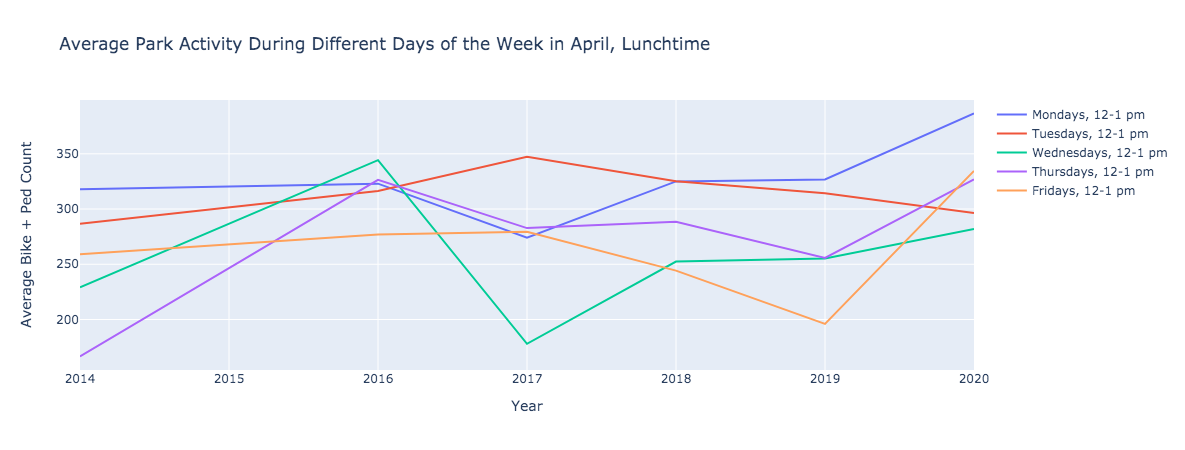

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Monday', datetime.time(12, 0)),
                    mode='lines',
                    name='Mondays, 12-1 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Tuesday', datetime.time(12, 0)),
                    mode='lines',
                    name='Tuesdays, 12-1 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Wednesday', datetime.time(12, 0)),
                    mode='lines',
                    name='Wednesdays, 12-1 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Thursday', datetime.time(12, 0)),
                    mode='lines',
                    name='Thursdays, 12-1 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Friday', datetime.time(12, 0)),
                    mode='lines',
                    name='Fridays, 12-1 pm'))
fig.update_layout(title='Average Park Activity During Different Days of the Week in April, Lunchtime',
                   xaxis_title='Year',
                   yaxis_title='Average Bike + Ped Count')
fig.show()

This data suggests that park usage on any given weekday in April 2020 is higher compared to the same weekday in 2019, except on Tuesdays, but compared to prior years there's no recognizable pattern. This is just the lunch hour though. Will this pattern hold after work hours?

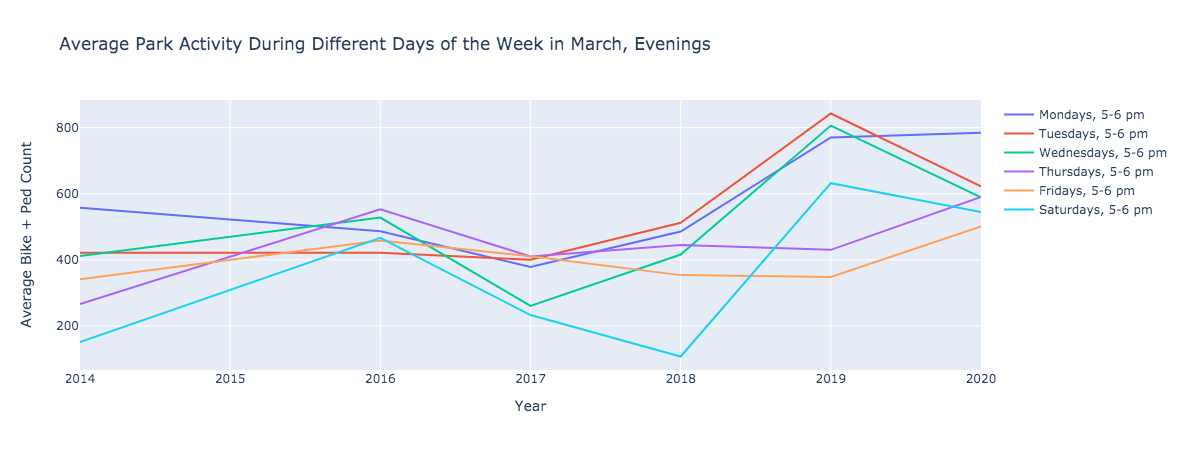

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Monday', datetime.time(17, 0)),
                    mode='lines',
                    name='Mondays, 5-6 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Tuesday', datetime.time(17, 0)),
                    mode='lines',
                    name='Tuesdays, 5-6 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Wednesday', datetime.time(17, 0)),
                    mode='lines',
                    name='Wednesdays, 5-6 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Thursday', datetime.time(17, 0)),
                    mode='lines',
                    name='Thursdays, 5-6 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Friday', datetime.time(17, 0)),
                    mode='lines',
                    name='Fridays, 5-6 pm'))
fig.add_trace(go.Scatter(x=allyears, y=counts_across_years('April', 'Saturday', datetime.time(17, 0)),
                    mode='lines',
                    name='Saturdays, 5-6 pm'))

fig.update_layout(title='Average Park Activity During Different Days of the Week in March, Evenings',
                   xaxis_title='Year',
                   yaxis_title='Average Bike + Ped Count')
fig.show()

Interestingly, the same pattern doesn't hold from the 5 to 6 pm hour, at least not every day. While Tuesday and Wednesday afternoons see a steep drop from 2019, Thursday and Fridays see increases. But while in 2019 there was  noticeably higher usage earlier in the week, in 2020 usage is converging on all days except Monday. Perhaps the pandemic has wiped away most of the weekly rhythms that distinguish one weekday from another. 

Now I'd like to get a sense of how usage varies throughout the day. This could help people determine the least crowded time to visit the park, for example. The function below takes a month, year, and weekday (for example, Fridays in March 2020) and returns average counts for each hour: average counts at 10am, average counts at 11am, etc.

In [17]:
def monthly_average_by_hour(month, year, weekday):
    hourly_average=[]
    hourlist = sorted(unique(APIrecords, 'Time'))
    for hour in hourlist:
        hourly_average.append(hourly_average_by_day(month, year, weekday, hour))
    return hourly_average
monthly_average_by_hour('April', 2020, 'Friday')
#it would be best if this were a dictionary so we could ensure keys and values are matched up.

[12.25,
 4.0,
 4.75,
 2.25,
 8.75,
 20.0,
 112.75,
 204.0,
 188.75,
 210.5,
 241.0,
 282.75,
 334.5,
 371.0,
 350.0,
 403.75,
 436.75,
 501.0,
 529.0,
 342.75,
 128.0,
 40.5,
 29.5,
 10.0]

That data looks about right, based on what I've observed on various of my own walks! Usage peaks in late afternoon when people get off work and it is warmer. For now I'm going to apply this function to different years in the dataset to compare trends year over year. But instead of Friday, I'll graph Wednesday, because in transportation terms you get a better picture of people's habits if you choose data in the middle of the week. 

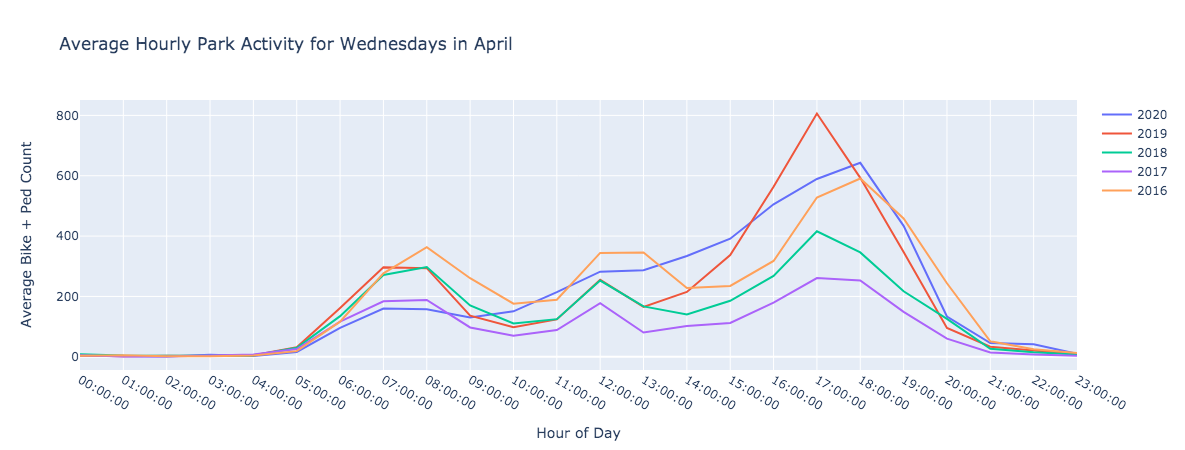

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=alltimes, y=monthly_average_by_hour('April', 2020, 'Wednesday'),
                    mode='lines',
                    name='2020'))
fig.add_trace(go.Scatter(x=alltimes, y=monthly_average_by_hour('April', 2019, 'Wednesday'),
                    mode='lines',
                    name='2019'))
fig.add_trace(go.Scatter(x=alltimes, y=monthly_average_by_hour('April', 2018, 'Wednesday'),
                    mode='lines',
                    name='2018'))
fig.add_trace(go.Scatter(x=alltimes, y=monthly_average_by_hour('April', 2017, 'Wednesday'),
                    mode='lines',
                    name='2017'))
fig.add_trace(go.Scatter(x=alltimes, y=monthly_average_by_hour('April', 2016, 'Wednesday'),
                    mode='lines',
                    name='2016'))
fig.update_layout(title='Average Hourly Park Activity for Wednesdays in April',
                   xaxis_title='Hour of Day',
                   yaxis_title='Average Bike + Ped Count')
fig.show()

So activity in April 2020 does not really stand out compared to other years.

So far we've been looking at April 2020 only as a whole. Let's zoom in on April 2020 by graphing hourly counts for every Friday that month. I posit that counts will creep up week after week, as more and more people begin working from home and looking for ways to get some exercise during and after work.

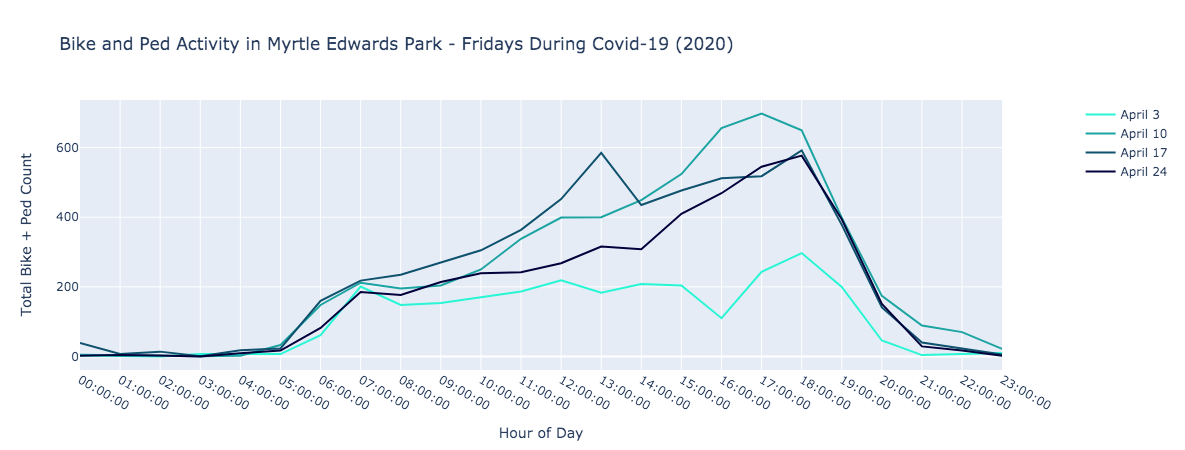

In [19]:
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=alltimes, y=hourlycounts('4/3/2020'),
                    mode='lines',
                    name='April 3',
                    line_color='rgb(40, 246, 212)'),
                    secondary_y=False)
fig.add_trace(go.Scatter(x=alltimes, y=hourlycounts('4/10/2020'),
                    mode='lines',
                    name='April 10',
                    line_color='rgb(27, 164, 161)'),
                    secondary_y=False)
fig.add_trace(go.Scatter(x=alltimes, y=hourlycounts('4/17/2020'),
                    mode='lines',
                    name='April 17',
                    line_color='rgb(15, 82, 110)'),
                    secondary_y=False)
fig.add_trace(go.Scatter(x=alltimes, y=hourlycounts('4/24/2020'),
                    mode='lines',
                    name='April 24',
                    line_color='rgb(3, 1, 60)'),
                    secondary_y=False)
#fig.add_trace(go.Scatter(x=[datetime.time(17, 0), datetime.time(17, 0), datetime.time(17, 0), datetime.time(17, 0)], y=[45, 44, 62, 50], name="High Temperature", text=['March 6', 'March 13', 'March 20', 'March 27']),
    #secondary_y=True,
    
#attempt to graph temperature on a secondary y axis, but didn't work well. 

fig.update_layout(title='Bike and Ped Activity in Myrtle Edwards Park - Fridays During Covid-19 (2020)',
                   xaxis_title='Hour of Day',
                   yaxis_title='Total Bike + Ped Count')
fig.show()

Well, I was wrong. Bicyle and pedestrian counts seem to vary quite a bit by day, and don't seem to be increasing over time. Could weather be a factor in day to day differences? Let's dig into some more data to find out.

#### Investigating Weather Factors

In [20]:
#x axis: weeks or days
#y axis: total count of the week
alldays = sorted(unique(APIrecords, 'Date')) #what is this for? not sure if sorting will matter once we have a df.

We can access historical high temperatures with NOAA's API:
    https://www.ncdc.noaa.gov/cdo-web/webservices/v2#gettingStarted

##### Accessing Weather Data

In [21]:
#import NOAA data for daily high temperatures.
url_2020 = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:98115&startdate=2020-01-01&enddate=2020-12-31&datatypeid=TMAX&limit=1000' #data response is limited to a one year range so I must break the request into chunks by years.
token = "jMDcJDHzHOqURxuLYjKuoPmwkwNuPyqP"

In [22]:
response_2020 = requests.get(url_2020, headers={'token': token})

The "value" here is the temperature, but it's recorded in celsius x10, as if it's missing a decimal point. We'll need to convert that, but for now we can work with it. 
We'll also need to call each year separately since there is a maximum number of records you can request at once.

In [23]:
url_2020 = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:98115&startdate=2020-01-01&enddate=2020-12-31&datatypeid=TMAX&limit=1000' 
url_2019 = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:98115&startdate=2019-01-01&enddate=2019-12-31&datatypeid=TMAX&limit=1000' 
url_2018 = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:98115&startdate=2018-01-01&enddate=2018-12-31&datatypeid=TMAX&limit=1000'
url_2017 = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:98115&startdate=2017-01-01&enddate=2017-12-31&datatypeid=TMAX&limit=1000' 
url_2016 = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:98115&startdate=2016-01-01&enddate=2016-12-31&datatypeid=TMAX&limit=1000' 
url_2015 = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:98115&startdate=2015-01-01&enddate=2015-12-31&datatypeid=TMAX&limit=1000' 
url_2014 = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&locationid=ZIP:98115&startdate=2014-01-01&enddate=2014-12-31&datatypeid=TMAX&limit=1000'


In [24]:
def send_request(url):
    token = "jMDcJDHzHOqURxuLYjKuoPmwkwNuPyqP"
    response = requests.get(url, headers={'token': token})
    data = response.json()
    results = data['results']
    results = pd.DataFrame.from_records(results)
    results['Date'] = pd.to_datetime(results['date']).dt.date
    results = results.rename(columns={"date": "Timestamp_Date"}) #dataframe of results
    records = results.to_dict('records')
    return records

In [27]:
#print(requests.get(url_2019, headers={'token': 'jMDcJDHzHOqURxuLYjKuoPmwkwNuPyqP'}).content)
#this suggests that there is a problem with the API.

In [28]:
weather_2020 = send_request(url_2020)    
#weather_2019 = send_request(url_2019)
#weather_2018 = send_request(url_2018)
#weather_2017 = send_request(url_2017)
#weather_2016 = send_request(url_2016)
#weather_2015 = send_request(url_2015)
#weather_2014 = send_request(url_2014)

#nothing before 2020 is working right now, so I am commenting them out in the hopes that it is an API issue that will get fixed. 

In [29]:
weather_list=[weather_2020]#, weather_2019, weather_2018, weather_2017, weather_2016, weather_2015, weather_2014]

##### Preparing Count Data for a Regression

First I want take the list of dictionaries `APIrecords` and return a single dictionary with date: count as the key: value pair. However, currently each record represents an hour, so I will need to aggregate these into total daily counts first using a new ``dailysum`` function I create below. 

In [30]:
def dailysum(date):
    strlist = hourlycounts(date) #produces a list of strings
    try: 
        intlist = list(map(int, strlist)) #converts list to integers
    except ValueError: #when data is NaN, give a 0 for that day but shouldn't affect other days
        intlist = 0
    return sum(intlist) #sums the integers

Next I will utilize the `unique` function I created earlier to generate a unique list of all dates in the dataset which I will then plug into the next function.

In [31]:
alldates = sorted(unique(APIrecords, 'Date')) 
testdates = alldates[:10] 

Finally I create `dict_of_counts` to get my dictionary with date:count as the key:value pair. I test it with the `testdates` list I created above, which is just a subset of the `alldates` list. `alldates` is over 2000 dates so it takes a long time to run.

In [32]:
def dict_of_counts(datelist):
    master_dict = dict()
    for date in datelist:
        master_dict.update({date: (dailysum(date))})
    return master_dict

In [ ]:
dict_of_counts(testdates)

##### Preparing Weather Data for a Regression

OK, that is the counts dictionary. Now I need to work on the high temperatures dictionary. Let's recall what we are working with here. Since `weather_2020` is a list of dictionaries, I can parse it and just call a few items to recall what format it is in.

In [33]:
weather_2020[:5]

[{'Timestamp_Date': '2020-01-01T00:00:00',
  'datatype': 'TMAX',
  'station': 'GHCND:USW00094290',
  'attributes': ',,W,2400',
  'value': 122,
  'Date': datetime.date(2020, 1, 1)},
 {'Timestamp_Date': '2020-01-02T00:00:00',
  'datatype': 'TMAX',
  'station': 'GHCND:USW00094290',
  'attributes': ',,W,2400',
  'value': 100,
  'Date': datetime.date(2020, 1, 2)},
 {'Timestamp_Date': '2020-01-03T00:00:00',
  'datatype': 'TMAX',
  'station': 'GHCND:USW00094290',
  'attributes': ',,W,2400',
  'value': 150,
  'Date': datetime.date(2020, 1, 3)},
 {'Timestamp_Date': '2020-01-04T00:00:00',
  'datatype': 'TMAX',
  'station': 'GHCND:USW00094290',
  'attributes': ',,W,2400',
  'value': 89,
  'Date': datetime.date(2020, 1, 4)},
 {'Timestamp_Date': '2020-01-05T00:00:00',
  'datatype': 'TMAX',
  'station': 'GHCND:USW00094290',
  'attributes': ',,W,2400',
  'value': 83,
  'Date': datetime.date(2020, 1, 5)}]

This looks promising, but the temperatures are still in the Celsius x 10 format (15.5 degrees Celsius is recorded as 155). When I create our dictionary of date:temperature I need to convert the temperatures to Fahrenheit, and I don't need to be too precise here, so I will round to the nearest degree. I start with a function to do the math:

In [34]:
def convert_temp(oldtemp):
    return round(((oldtemp *9/50)+32),0)

convert_temp(255)

78.0

In [35]:
def dict_of_temps(records): #takes a list of dictionaries from NOAA dataset and returns a single dictionary with Date: Temperature as key: value. only one year at a time.
    master_dict = dict()
    for record in records: #record would be a dictionary containing one date with one temp reading if `records` is a list of dictionaries. 
        master_dict.update({record['Date']: convert_temp(record['value'])})
    return master_dict

#dict_of_temps(weather_2020) #right now only 2020 is working because of API issue.

In [36]:
all_temps = dict() #master dictionary of temperatures for all years in dataset.
for year in weather_list:
    all_temps.update(dict_of_temps(year)) #will this nest the dictionaries? I want them all just combined into one. 

The dictionary works, and the temperatures look reasonable for their respective times of year. Great! Now I need to create a new dataframe with temperature and count so I can associate each one with the same date and therefore ensure that the temperature and count are matched properly when I do a regression.

In [ ]:
#dict_of_counts = dict_of_counts(alldates) #this function takes forever to run. need to change it. 

##better idea than everything so far
create a dataframe with the date as the index and counts and temps each as columns
then get the x and y val from the dataframe

#here's one try, but so far it's too slow: creating a dataframe from counts
counts_df = pd.DataFrame(dict_of_counts(alldates))
counts_df.head()

In [ ]:
#alternatively, what if we just create a series from each dict?
counts_series = pd.Series(dict_of_counts(alldates))
counts_series.index = dict_of_counts(alldates).keys()
counts_series.head()

In [ ]:
temp_series = pd.Series(dict_of_temps(weather_2020))
temp_series.index = dict_of_temps(weather_2020).keys() #when we combine, we will see if these are in the same format as in dict_of_counts
temp_series.head()

In [ ]:
df_dict = {'count':counts_series, 'temperature':temp_series}
df = pd.DataFrame(df_dict)
df.head()

next steps for linear regression:
scatterplot of temperature, usage
- dataframe to generate x and y values
- plot, look for trends, color 2020 differently to spot trends.
plot a starting regression line and calculate RSS
- see lesson 16, starting on page 7
how can I access functions that i've written in other notebooks? "from _ import _"


In [ ]:
#y-values for trace
def count_values(datelist): 
    counts=[]
    for date in datelist:
        counts.append(dailysum(date)) 
    return counts

count_values(testdates) #does this have count data? it should, because it calls `dailysum()`

In [ ]:
#def temp_values(datelist): #x-values for trace
    temps=[]
    for date in datelist:
        temps.append()
    return temps

temp_values(alltemps)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=__, y=__,
                    mode='lines',
                    name=''))
fig.update_layout(title='Trail Usage as a Function of Temperature',
                   xaxis_title='High Temperature (F)',
                   yaxis_title='Daily Trail Usage')
fig.show()
